<a href="https://colab.research.google.com/github/ebi19912/AI/blob/main/ConvNeXtLarge_ChestClassification_wbce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!kaggle datasets download -d khanfashee/nih-chest-x-ray-14-224x224-resized

!unzip nih-chest-x-ray-14-224x224-resized.zip

Streaming output truncated to the last 5000 lines.
  inflating: images-224/images-224/00028897_017.png  
  inflating: images-224/images-224/00028897_018.png  
  inflating: images-224/images-224/00028897_019.png  
  inflating: images-224/images-224/00028897_020.png  
  inflating: images-224/images-224/00028898_000.png  
  inflating: images-224/images-224/00028899_000.png  
  inflating: images-224/images-224/00028899_001.png  
  inflating: images-224/images-224/00028899_002.png  
  inflating: images-224/images-224/00028900_000.png  
  inflating: images-224/images-224/00028901_000.png  
  inflating: images-224/images-224/00028901_001.png  
  inflating: images-224/images-224/00028902_000.png  
  inflating: images-224/images-224/00028902_001.png  
  inflating: images-224/images-224/00028902_002.png  
  inflating: images-224/images-224/00028902_003.png  
  inflating: images-224/images-224/00028902_004.png  
  inflating: images-224/images-224/00028902_005.png  
  inflating: images-224/images-

In [ ]:
!pip install tensorflow keras seaborn

import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ConvNeXtLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import AvgPool2D, MaxPool2D, ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,
    matthews_corrcoef, average_precision_score, precision_recall_curve, roc_curve, roc_auc_score
)

from tensorflow.compat.v1.logging import INFO, set_verbosity
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import rcParams
from keras.preprocessing import image


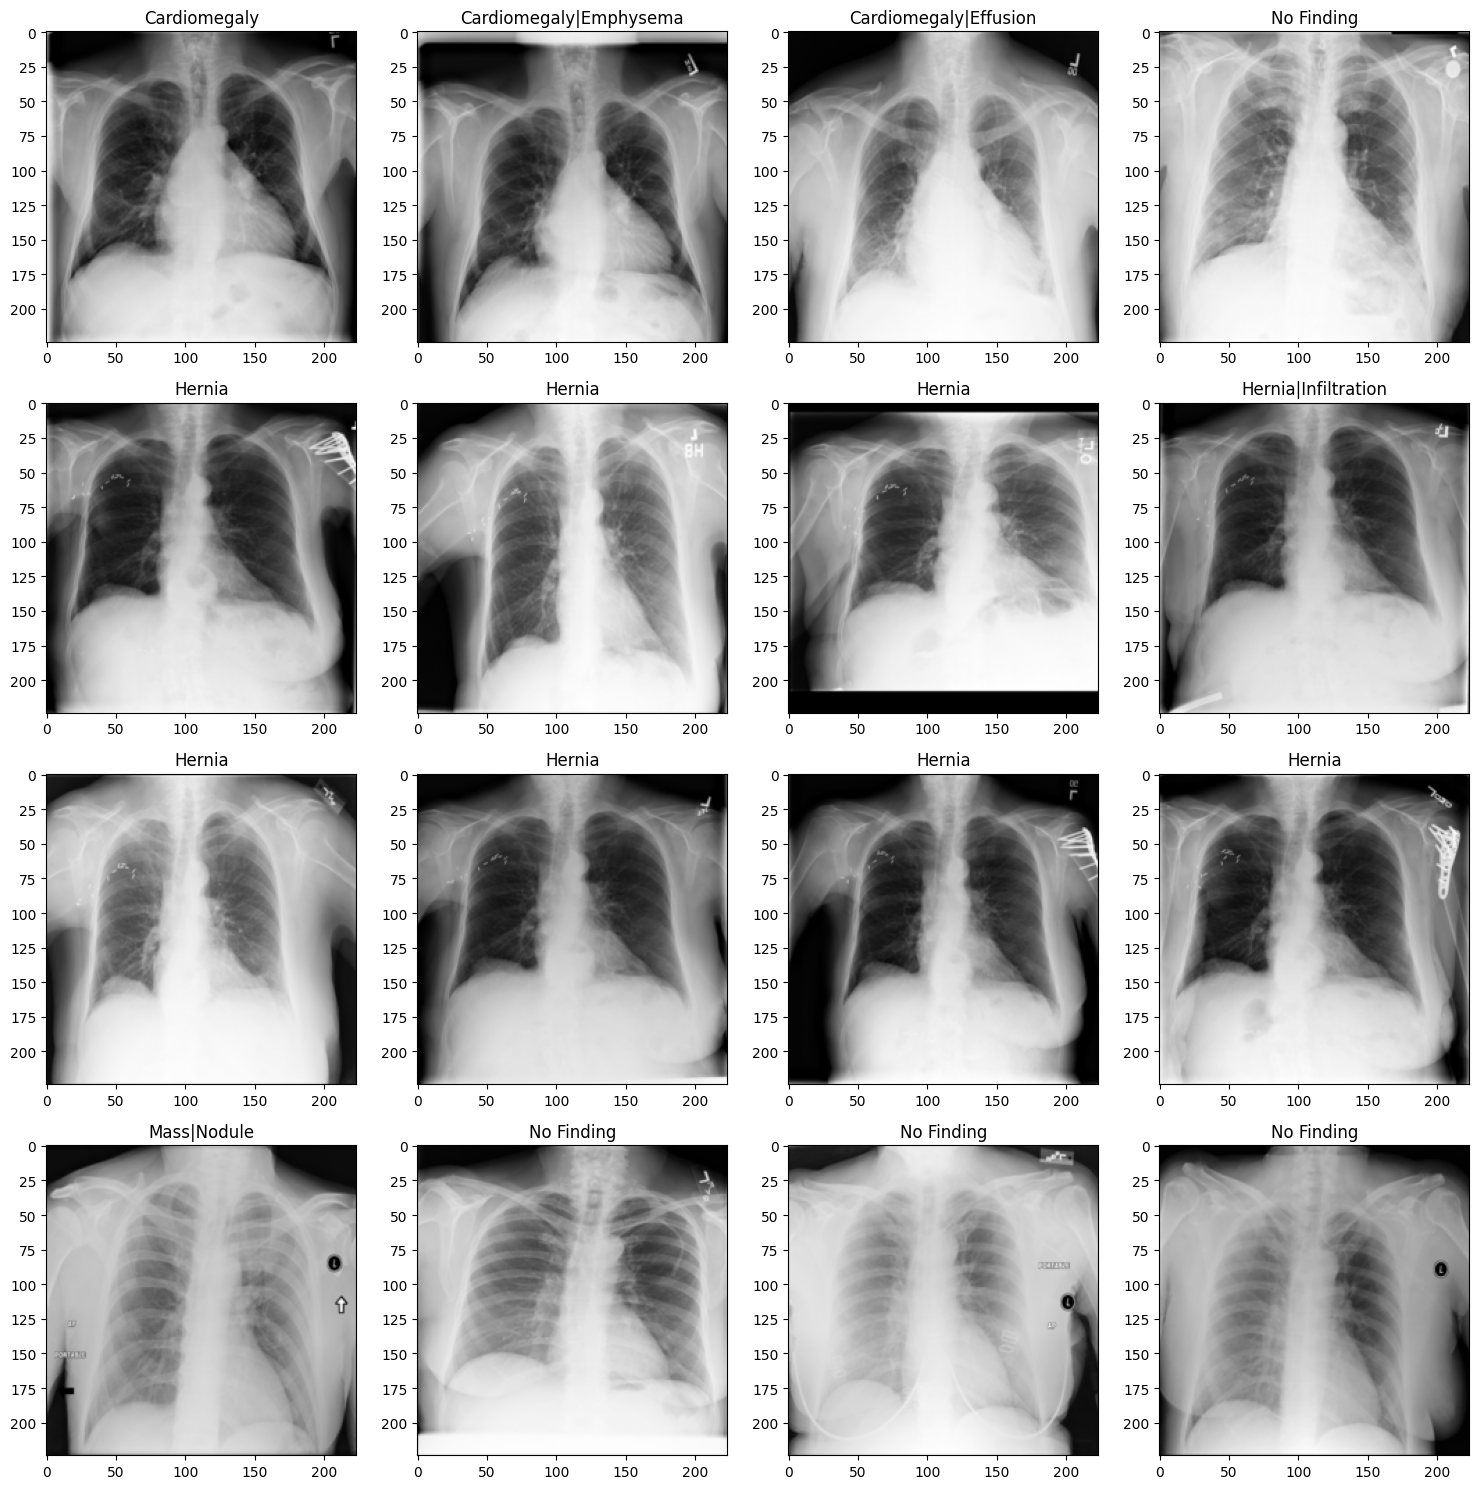

In [ ]:
dataframe = pd.read_csv("/content/Data_Entry_2017.csv")

#Enumerating all column names
columns = ["Image"]
for i in dataframe["Finding Labels"].values:
    for j in i.split("|"):
        if j not in columns:
            columns.append(j)
labels = columns.copy()
labels.remove("Image")

#Taking the first 20000 images from the master table as the train dataset
trainset = pd.DataFrame(columns = columns)
for i in range(20000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    trainset.loc[len(trainset)] = col

#Taking the next 2000 images from the master table as the validation dataset
valset = pd.DataFrame(columns = columns)
for i in range(20000, 22000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    valset.loc[len(valset)] = col

#Taking the next 2000 images from the master table as the test dataset
testset = pd.DataFrame(columns = columns)
for i in range(22000, 24000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    testset.loc[len(testset)] = col

#Plotting first 16 images with their disease labels
img_dir = "/content/images-224/images-224"
plt.figure(figsize = (15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(img_dir, trainset["Image"][i])), cmap = "gray")
    plt.title(dataframe[dataframe["Image Index"] == trainset["Image"][i]].values[0][1])
plt.tight_layout()

In [ ]:
def isOverlap(s1, s2):
    total = set(s1).intersection(set(s2))
    return [len(total), total]

def overlapcheck(trainset, valset, testset):
    patid_train = []
    patid_val = []
    patid_test = []
    for name in trainset['Image'].values:
        patid_train.append(int(name.split("_")[0]))

    for name in valset['Image'].values:
        patid_val.append(int(name.split("_")[0]))

    for name in testset['Image'].values:
        patid_test.append(int(name.split("_")[0]))
    trte = isOverlap(patid_train, patid_test)
    teva = isOverlap(patid_test, patid_val)
    trva = isOverlap(patid_train, patid_val)
    print("Patient Overlap - Train and Test: ", trte[0])
    print("Patient Overlap - Test and Validation: ", teva[0])
    print("Patient Overlap - Train and Validation: ", trva[0])
    return trte, teva, trva

#Checking for overlaps between trainset, testset and validation set
trte, teva, trva = overlapcheck(trainset, valset, testset)

#Removing overlapping patients
for i in trva[1]:
    for name in trainset['Image'].values:
        if(int(name.split("_")[0]) == i):
            trainset.drop(trainset.loc[trainset['Image'] == name].index, inplace=True)

#Checking for overlaps after removing common patients
trte, teva, trva = overlapcheck(trainset, valset, testset)

Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  0
Patient Overlap - Train and Validation:  1
Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  0
Patient Overlap - Train and Validation:  0


In [ ]:
def label_counts(df):
    label_counts = df[labels].sum().sort_values(ascending=False)
    return label_counts

print("Training Data Label Counts:")
print(label_counts(trainset))
print("\nValidation Data Label Counts:")
print(label_counts(valset))
print("\nTest Data Label Counts:")
print(label_counts(testset))

Training Data Label Counts:
No Finding            11720
Infiltration           2952
Effusion               1844
Atelectasis            1795
Nodule                  904
Pneumothorax            803
Consolidation           726
Cardiomegaly            692
Mass                    639
Pleural_Thickening      622
Fibrosis                467
Emphysema               382
Edema                   273
Pneumonia               225
Hernia                   53
dtype: int64

Validation Data Label Counts:
No Finding            1071
Infiltration           320
Atelectasis            224
Effusion               201
Nodule                 141
Pneumothorax            84
Mass                    78
Consolidation           78
Pleural_Thickening      59
Cardiomegaly            59
Emphysema               57
Fibrosis                41
Edema                   30
Pneumonia               25
Hernia                   1
dtype: int64

Test Data Label Counts:
No Finding            1213
Infiltration           313
Effusion   

Maximum Pixel Value:  0.9647059
Minimum Pixel Value:  0.0
Image dimension: 224 x 224 
Mean - Pixel Value:  0.6730806
Std Deviation Pixel Value:  0.24200587


<Axes: xlabel='Pixel Values', ylabel='Count'>

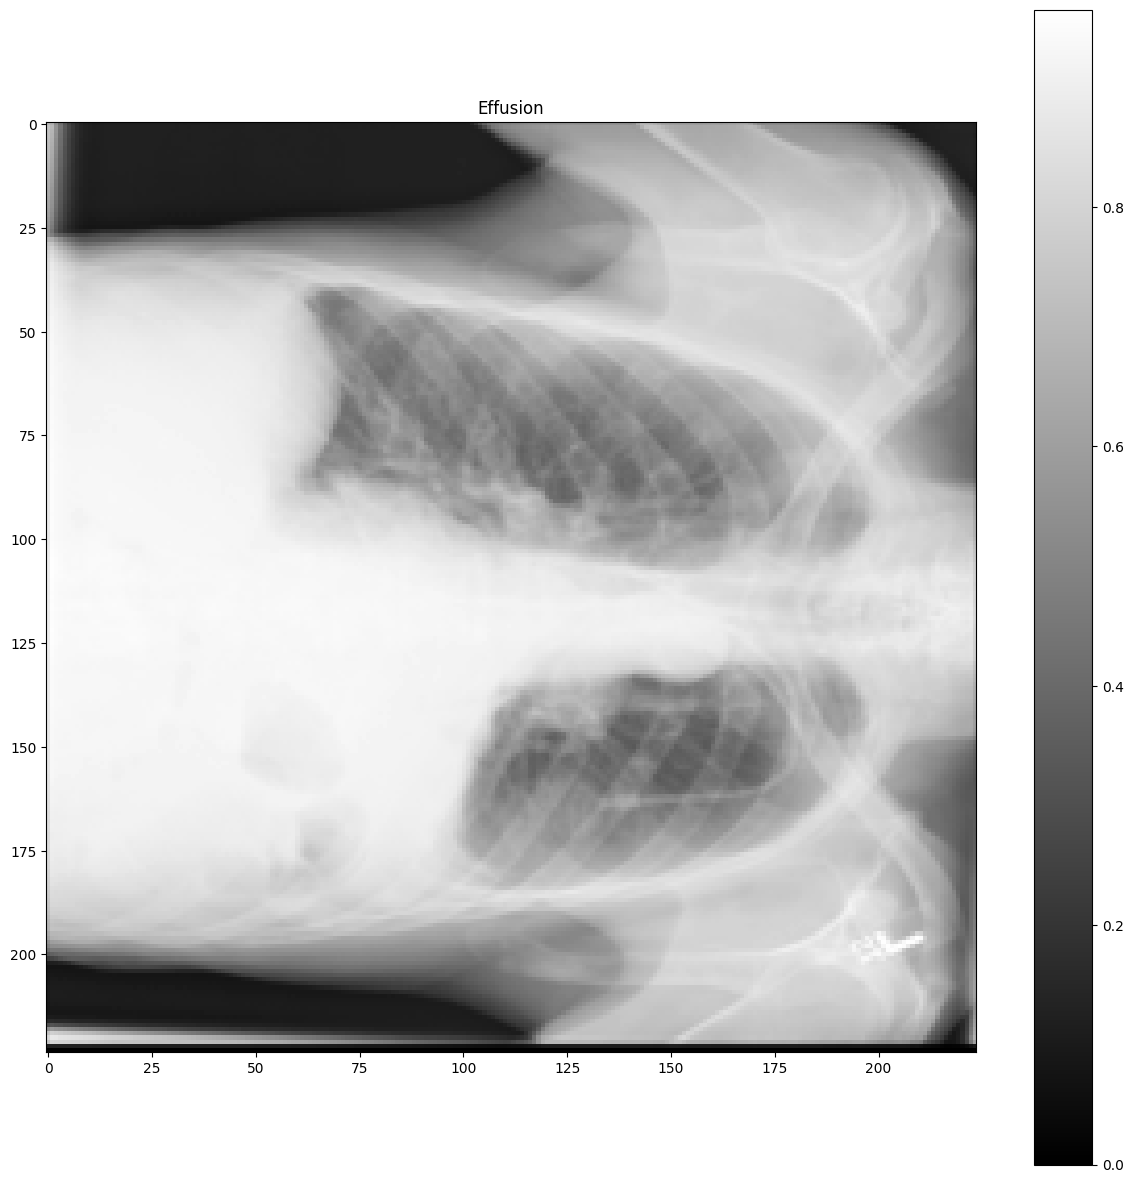

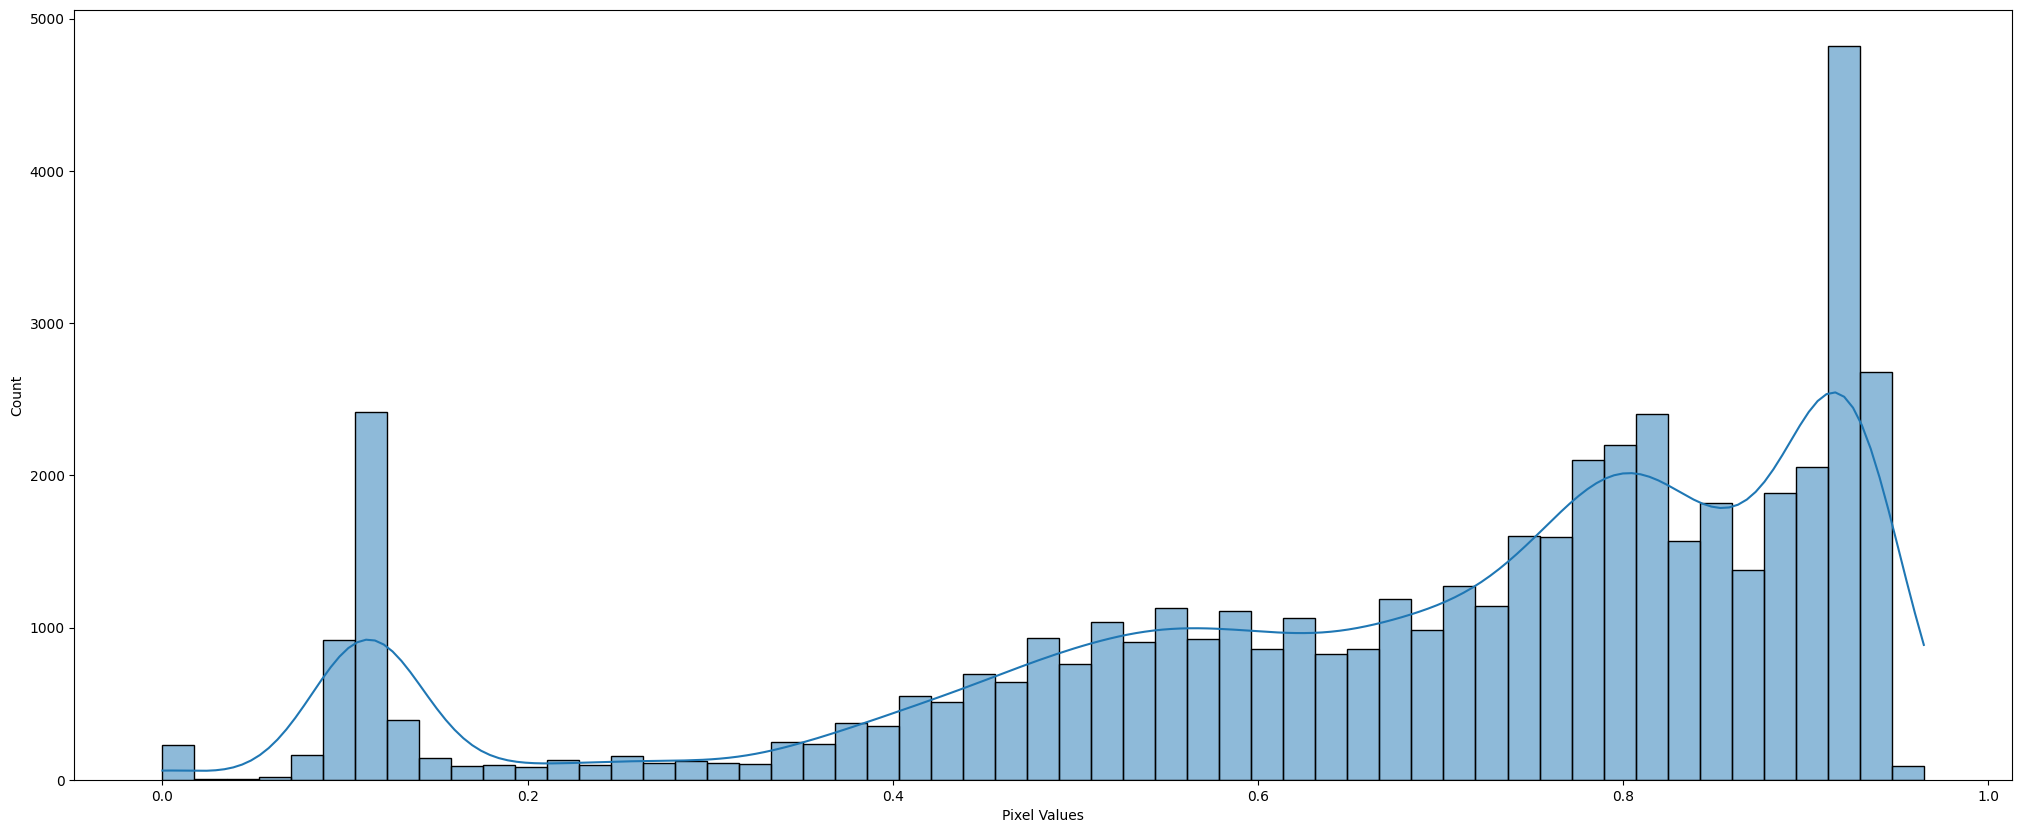

In [ ]:
num = np.random.randint(trainset.shape[0])
sample = plt.imread(os.path.join(img_dir,trainset.iloc[[num]]["Image"].values[0]))
plt.figure(figsize=(15, 15))
plt.title(dataframe[dataframe["Image Index"] == trainset.iloc[[num]]["Image"].values[0]].values[0][1])
plt.imshow(sample, cmap = 'gray')
plt.colorbar()
trainset.iloc[[num]]

print("Maximum Pixel Value: ", sample.max())
print("Minimum Pixel Value: ", sample.min())
print(f"Image dimension: {sample.shape[0]} x {sample.shape[1]} ")

fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean - Pixel Value: ", sample.mean())
print("Std Deviation Pixel Value: ", sample.std())
sns.histplot(sample.ravel(), ax = ax, kde = True)

Found 19989 validated image filenames.
Found 19989 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


Mean of Pixel Values - Standardized:  -8.3608694e-07
Standard Deviation of Pixel Values - Standardized:  1.0000001
Mean of Pixel Values - Sample:  0.6730806
Standard Deviation of Pixel Values - Sample:  0.24200587


<Axes: xlabel='Pixel Values', ylabel='Count'>

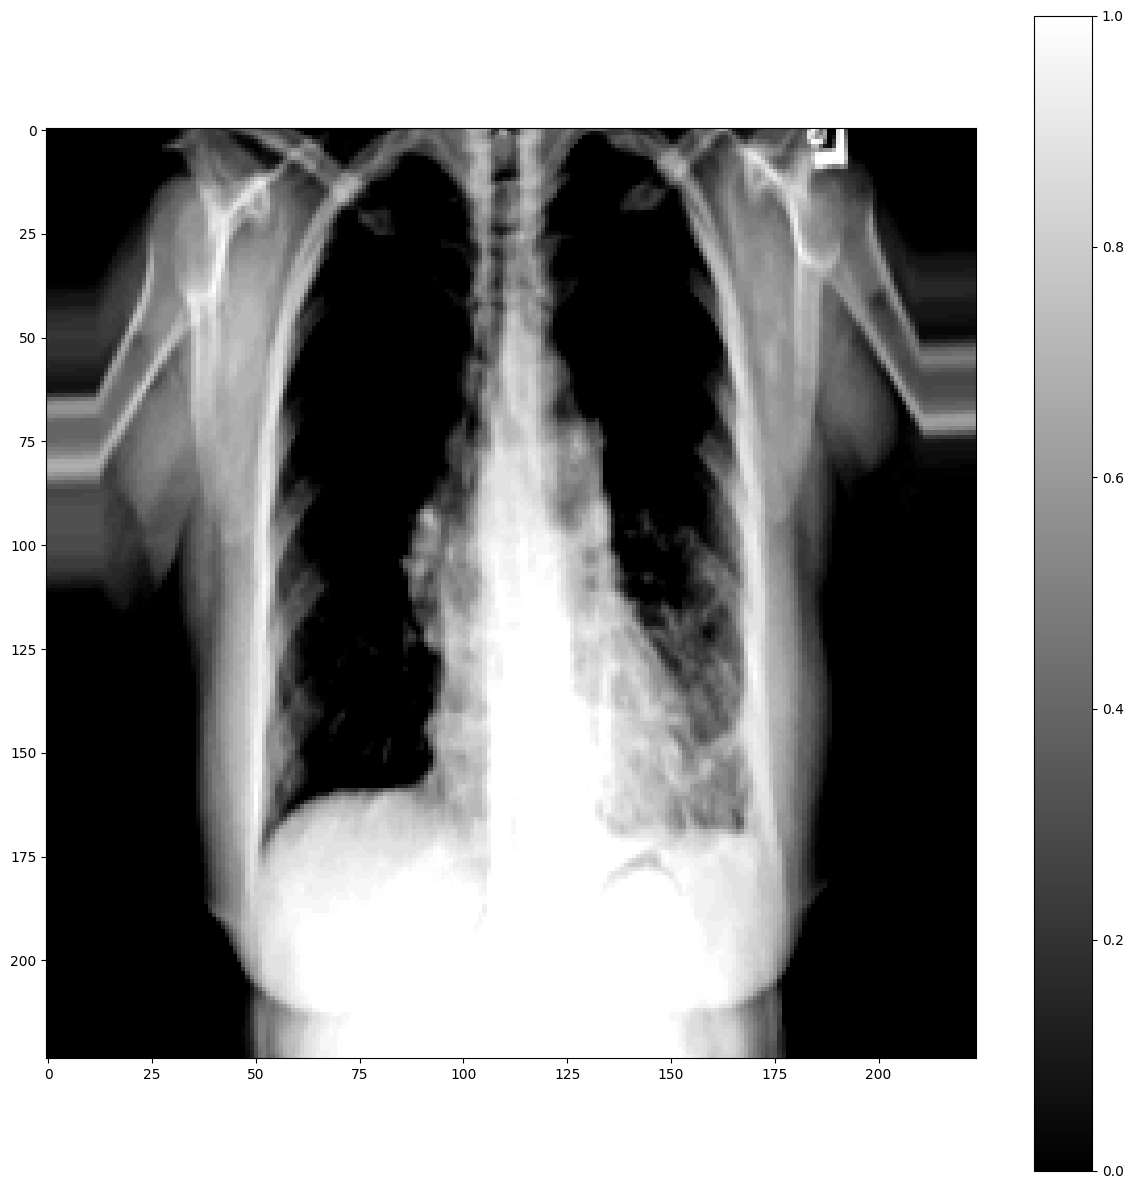

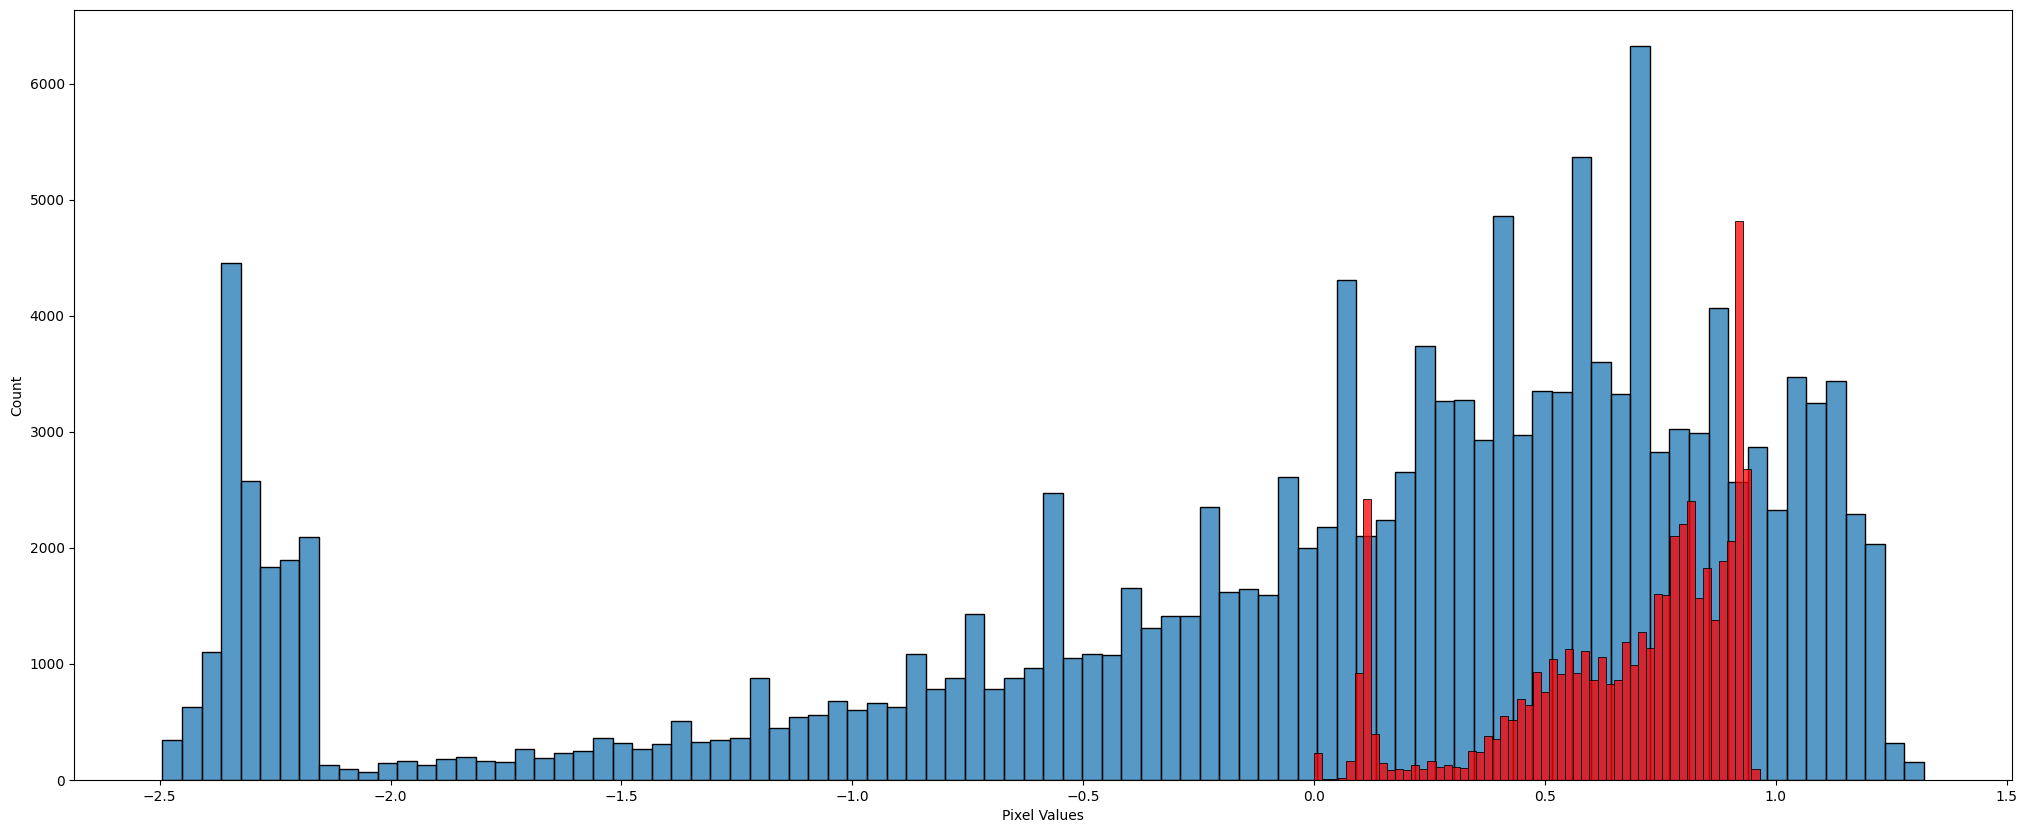

In [ ]:
def adjust_contrast_and_saturation(image):
  # Generate a random contrast factor between 0.4 and 0.9
  contrast_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_contrast(image, contrast_factor)

  # Generate a random saturation factor between 0.4 and 0.9
  saturation_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_saturation(image, saturation_factor)

  return image

traingen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.3, 1.2],
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=adjust_contrast_and_saturation
)
img_dir = "/content/images-224/images-224"
bach=8
traingenerator = traingen.flow_from_dataframe(
        dataframe=trainset,
        directory=img_dir,
        x_col="Image",
        y_col= labels,
        class_mode="raw",
        batch_size= bach,
        shuffle=False,
        target_size=(224,224)
)
#Standardizing featurewise as we don't process images as groups rather one-by-one
imagegen = ImageDataGenerator().flow_from_dataframe(dataframe = trainset,
                                                    directory = img_dir,
                                                    x_col = "Image",
                                                    y_col = labels, class_mode = "raw",
                                                    batch_size= bach,
                                                    shuffle=False,
                                                    target_size=(224,224))
train_sample = next(imagegen)[0]
imagegen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization= True)
imagegen.fit(train_sample)
valgenerator = imagegen.flow_from_dataframe(dataframe = valset,
                                            directory = img_dir,
                                            x_col = "Image",
                                            y_col = labels,
                                            class_mode = "raw",
                                            batch_size= bach,
                                            shuffle=False,
                                            target_size=(224,224))
testgenerator = imagegen.flow_from_dataframe(dataframe = testset,
                                             directory = img_dir,
                                             x_col = "Image",
                                             y_col = labels,
                                             class_mode = "raw",
                                             batch_size= bach,
                                             shuffle=False,
                                             target_size=(224,224))


#Taking a random sample standardized image
num = np.random.randint(len(traingenerator))

item, value = traingenerator.__getitem__(num)
plt.figure(figsize=(15, 15))
plt.imshow(item[0], cmap = 'gray')
plt.colorbar()

#Plotting the histogram of original and standardized pixel intensities
fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean of Pixel Values - Standardized: ", item[0].mean())
print("Standard Deviation of Pixel Values - Standardized: ", item[0].std())
print("Mean of Pixel Values - Sample: ", sample.mean())
print("Standard Deviation of Pixel Values - Sample: ", sample.std())
sns.histplot(item[0].ravel(), ax = ax, kde = False)
sns.histplot(sample.ravel(), ax = ax, kde = False, color = "red")

<Figure size 2000x1500 with 0 Axes>

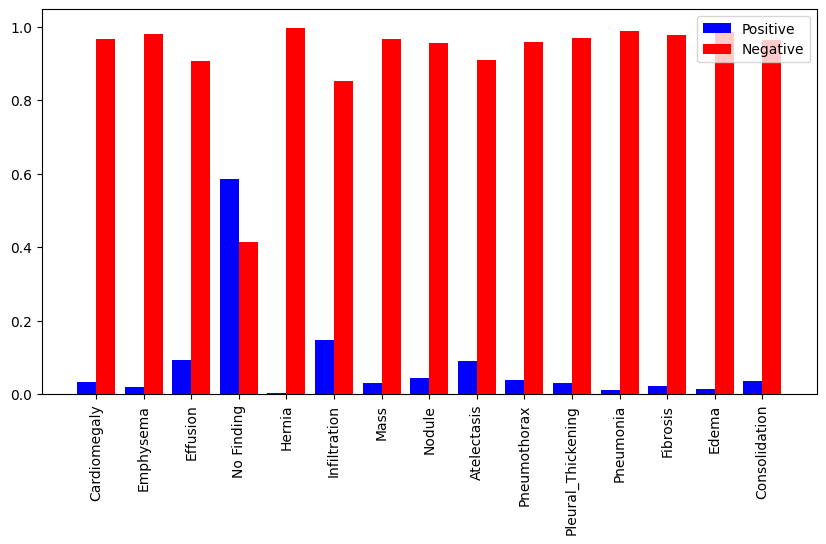

<Figure size 2000x1500 with 0 Axes>

In [ ]:
# Calculate positive and negative frequencies for each label
positive_freqs = trainset[labels].sum().values / trainset.shape[0]  # Assuming labels are 1 for positive, 0 for negative
negative_freqs = 1 - positive_freqs

data = {
    'Class': labels,
    'Positive': positive_freqs, #* negative_freqs, #Removed
    'Negative': negative_freqs #* positive_freqs #Removed
}

X_axis = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(X_axis-0.2, data['Positive'], width=0.4, color='b', label = "Positive")
ax.bar(X_axis+0.2, data['Negative'], width=0.4, color='r', label = 'Negative')
plt.xticks(X_axis, labels, rotation = 90)
plt.legend()
plt.figure(figsize=(20,15))

In [ ]:
# Assuming you have your labels and save directory defined

save_dir = '/content/drive/My Drive/saved_models/'
os.makedirs(save_dir, exist_ok=True)

# Define a function to create the model
def create_model():
    # Input layer
    input_tensor = Input(shape=(224, 224, 3))

    # ConvNeXtLarge  branch
    ConvNeXtLarge_base = ConvNeXtLarge(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in ConvNeXtLarge_base.layers[:-4]:  # Fine-tuning: Unfreeze the last 5 layers
        layer.trainable = False
    ConvNeXtLarge_x = ConvNeXtLarge_base.output
    ConvNeXtLarge_x = GlobalAveragePooling2D()(ConvNeXtLarge_x)
    ConvNeXtLarge_x = Dense(256, activation='relu')(ConvNeXtLarge_x)

    # Output layer with sigmoid for multi-label classification
    output = Dense(len(labels), activation='sigmoid')(ConvNeXtLarge_x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output)

    return model

# Create the ConvNeXtLarge model
model = create_model()
model.summary()

785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_prestem_n… │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stem       │ (None, 56, 56, 192)    │          9,792 │ convnext_large_preste… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 192)    │          9,600 │ convnext_large_stem[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 192)    │            384 │ convnext_large_stage_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 768)    │        148,224 │ convnext_large_stage_… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 768)    │              0 │ convnext_large_stage_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 192)    │        147,648 │ convnext_large_stage_… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 192)    │            192 │ convnext_large_stage_… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 192)    │              0 │ convnext_large_stage_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 192)    │              0 │ convnext_large_stem[0… │
│                           │                        │                │ convnext_large_stage_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 192)    │          9,600 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_0_b… │ (None, 56, 56, 192)    │            384 │ convnext_large_stage_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_large_stage_

 Total params: 196,627,663 (750.08 MB)

 Trainable params: 9,840,655 (37.54 MB)

 Non-trainable params: 186,787,008 (712.54 MB)

In [ ]:
def weighted_cross_entropy(y_true, y_pred):
    # Calculate positive and negative weights based on class frequencies in your dataset.
    positive_weights = tf.constant(positive_freqs, dtype=tf.float32)  # Example positive weights
    negative_weights = tf.constant(negative_freqs, dtype=tf.float32)  # Example negative weights

    # Calculate the weighted loss
    loss = -(y_true * tf.math.log(y_pred + 1e-7) * positive_weights + (1 - y_true) * tf.math.log(1 - y_pred + 1e-7) * negative_weights)

    return tf.reduce_mean(loss)

In [ ]:
# Function to train the model and save it
def train_and_save_model(model_name):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy, metrics=['accuracy'])

    # Define callbacks
    checkpoint = ModelCheckpoint(f'{model_name}.keras',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        traingenerator,
        epochs=100,steps_per_epoch=100,
        validation_data=valgenerator,
        callbacks=[checkpoint, early_stopping]
    )

    return history

# Train the model and save it
history = train_and_save_model('ConvNeXtLarge_chest_xray_ensemble')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5306 - loss: 0.3438
Epoch 1: val_loss improved from inf to 0.15185, saving model to ConvNeXtLarge_chest_xray_ensemble.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 124s 947ms/step - accuracy: 0.5308 - loss: 0.3429 - val_accuracy: 0.5355 - val_loss: 0.1518
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5720 - loss: 0.1225
Epoch 2: val_loss improved from 0.15185 to 0.08710, saving model to ConvNeXtLarge_chest_xray_ensemble.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 905ms/step - accuracy: 0.5721 - loss: 0.1223 - val_accuracy: 0.5355 - val_loss: 0.0871
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6160 - loss: 0.0715
Epoch 3: val_loss improved from 0.08710 to 0.06447, saving model to ConvNeXtLarge_chest_xray_ensemble.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 886ms/step - accuracy: 0.6161 - loss: 0.0714 - val_accuracy: 0.5355 - val_loss: 0.0645
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 25: val_loss did not improve from 0.04111
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 780ms/step - accuracy: 0.5896 - loss: 0.0377 - val_accuracy: 0.5355 - val_loss: 0.0412
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5701 - loss: 0.0386
Epoch 26: val_loss did not improve from 0.04111
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 808ms/step - accuracy: 0.5703 - loss: 0.0386 - val_accuracy: 0.5355 - val_loss: 0.0412
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.5783 - loss: 0.0393
Epoch 27: val_loss improved from 0.04111 to 0.04108, saving model to ConvNeXtLarge_chest_xray_ensemble.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5783 - loss: 0.0393 - val_accuracy: 0.5355 - val_loss: 0.0411
Epoch 28/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6243 - loss: 0.0365
Epoch 28: val_loss improved from 0.04108 to 0.04104, saving model to ConvNeXtLarge_chest_xray_ensemble.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.6

250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 189ms/step
Best threshold for Cardiomegaly: 0.0016
Confusion Matrix for Cardiomegaly (Threshold: 0.0016):
[[1012  963]
 [   8   17]]
Specificity for Cardiomegaly: 0.5124050632911392
Best threshold for Emphysema: 0.00030000000000000003
Confusion Matrix for Emphysema (Threshold: 0.00030000000000000003):
[[ 238 1739]
 [   2   21]]
Specificity for Emphysema: 0.12038442083965605
Best threshold for Effusion: 0.0111
Confusion Matrix for Effusion (Threshold: 0.0111):
[[948 854]
 [ 59 139]]
Specificity for Effusion: 0.5260821309655938
Best threshold for No Finding: 0.0001
Confusion Matrix for No Finding (Threshold: 0.0001):
[[   0  787]
 [   0 1213]]
Specificity for No Finding: 0.0
Best threshold for Hernia: 0.00030000000000000003
Confusion Matrix for Hernia (Threshold: 0.00030000000000000003):
[[ 327 1671]
 [   0    2]]
Specificity for Hernia: 0.16366366366366367
Best threshold for Infiltration: 0.04340000000000001
Confusion Matrix for Infiltration (Threshold: 

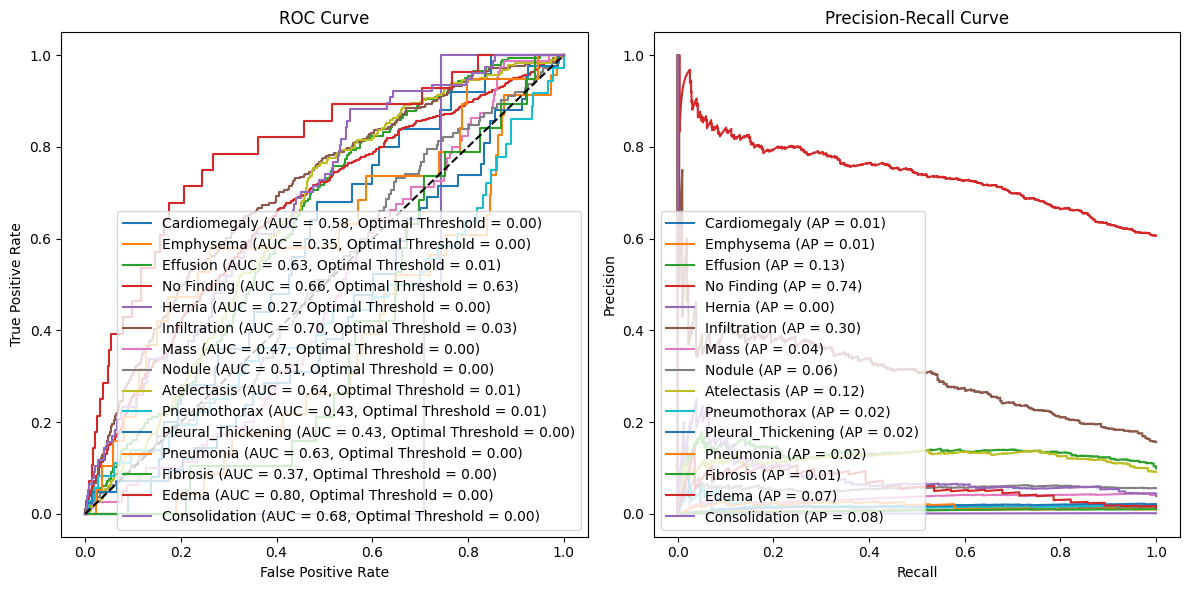

In [ ]:
# Initialize lists to store evaluation metrics for each label
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
mcc_list = []
auc_pr_list = []
best_thresholds = []
predicted_vals = model.predict(testgenerator)
# Iterate through labels and calculate metrics
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred_probs = predicted_vals[:, i]

        # Find optimal threshold based on F1-score
        best_f1 = -1
        best_thresh = 0
        for thresh in np.arange(0.0001, 0.0999999, 0.0001):  # Iterate through different thresholds
            pred = (pred_probs > thresh).astype(int)
            f1 = f1_score(gt, pred)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Best threshold for {labels[i]}: {best_thresh}")

        # Use the best threshold for evaluation
        pred = (pred_probs > best_thresh).astype(int)

        precision = precision_score(gt, pred)
        recall = recall_score(gt, pred)
        f1 = f1_score(gt, pred)
        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        auc_pr = average_precision_score(gt, pred_probs)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        mcc_list.append(mcc)
        auc_pr_list.append(auc_pr)

        # Calculate Confusion Matrix
        cm = confusion_matrix(gt, pred)
        print(f"Confusion Matrix for {labels[i]} (Threshold: {best_thresh}):")
        print(cm)
        # Calculate Specificity
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        print(f"Specificity for {labels[i]}: {specificity}")

    except ValueError:
        pass


# Store the metrics in a DataFrame for better presentation
metrics_df = pd.DataFrame({
    'Label': labels,
    'Best Threshold': best_thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_list,
    'Accuracy': accuracy_list,
    'MCC': mcc_list,
    'AUC-PR': auc_pr_list
})

print(metrics_df)

# Plot ROC and PR curves for each label in one plot
plt.figure(figsize=(12, 6))

# ROC curve
plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred = predicted_vals[:, i]
        fpr, tpr, thresholds = roc_curve(gt, pred)

        # Calculate Youden's J for each threshold
        youden_j = tpr - fpr

        # Find the optimal threshold based on Youden's J
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        roc_auc = roc_auc_score(gt, pred)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Optimal Threshold = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# PR curve
plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred = predicted_vals[:, i]
        precision, recall, _ = precision_recall_curve(gt, pred)
        average_precision = average_precision_score(gt, pred)
        plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()